# Cluster
정기예금 텔레마케팅 캠페인 데이터로부터 고객을 클러스터링합니다.

In [1]:
# enable in-line MatPlotLib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

# Import modules

In [45]:
import pandas as pd
from copy import deepcopy
import sys
from kmodes import kprototypes
from sklearn.preprocessing import MinMaxScaler
from util import modify_max_outlier
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
RANDOM_SEED = 99

# Read data
df = pd.read_csv("dataset.tsv", delimiter='\t')

# Preprocess

In [39]:
replace_dict = {
    "x4":{"저학력":"low", "중학력":"middle", "고학력":"high"}
    }

df.replace(replace_dict, inplace=True)

df.drop(['x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'y'], axis=1, inplace=True)

df[['x1', 'x6']] = df[['x1', 'x6']].astype(float)

거리 기반의 알고리즘 사용을 위해서는 scale 조정이 필요합니다. 탐색 단계에서 확인한 x6 변수의 out-lier를 제거하고, numeric data의 스케일을 동일하게 변경합니다. 정규 분포와 가깝지는 않으므로 MinMax방식의 scale 조정을 합니다.

In [40]:
# Modify Out-lier
#plotOutlier(df['x6'].sample(1000))
df.x6 = modify_max_outlier(df, col='x6', max=6000)

raw_df = deepcopy(df)

mms = MinMaxScaler()
df[['x1', 'x6']] = mms.fit_transform(df[['x1', 'x6']])

In [41]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8
0,0.519481,management,married,high,no,0.357167,yes,no
1,0.337662,technician,single,middle,no,0.004833,yes,no
2,0.194805,entrepreneur,married,middle,no,0.000333,yes,yes
3,0.376623,blue-collar,married,unknown,no,0.251000,yes,no
4,0.194805,unknown,single,unknown,no,0.000167,no,no


In [42]:
raw_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8
0,58.0,management,married,high,no,2143.0,yes,no
1,44.0,technician,single,middle,no,29.0,yes,no
2,33.0,entrepreneur,married,middle,no,2.0,yes,yes
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no
4,33.0,unknown,single,unknown,no,1.0,no,no


# Clustering algorithm
k-prototype 알고리즘을 사용합니다. (참고: https://grid.cs.gsu.edu/~wkim/index_files/papers/kprototype.pdf) (라이브러리: https://github.com/nicodv/kmodes) numeric data만으로 이루어진 경우에는 k-means를, categorical data만으로 이루어진 경우는 k-modes 알고리즘을 사용가능합니다. 현재 데이터는 혼합된 형태입니다. 먼저 적절한 cluster의 수(k)를 찾습니다. 알고리즘 수행 시간을 줄이기 위해 sampling을 사용합니다.

In [43]:
X_sample = df.sample(n=4000, replace=False, random_state=RANDOM_SEED)

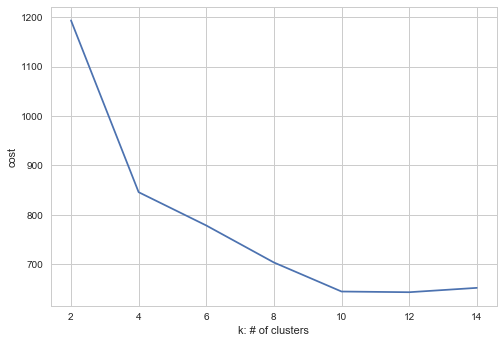

In [46]:
# Run algorithm with the different number of clusters
k_range = range(2, 16, 2)
cost = []
for k in k_range:
    kproto = kprototypes.KPrototypes(n_clusters=k, init='Cao')
    clusters = kproto.fit_predict(X_sample.as_matrix(), categorical=[1, 2, 3, 4, 6, 7])
    cost.append(kproto.cost_)

# Plot cost with the number of clusters
sns.set_style('whitegrid')
plt.plot(k_range, cost)
plt.xlabel('k: # of clusters')
plt.ylabel('cost')
sns.plt.show()

Cluster 수를 결정하기 위해서 가장 간단한 방법인 The Elbow Method를 사용합니다. 일반적으로는 이 방법으로 대략적인 cluster의 범위를 구하고 F-test 또는 ANOVA Test를 통해서 cluster의 적절성 여부를 판단합니다. 현재 데이터는 dummy variable이 다수 발생하고, sample이 표준 분포를 따른다고 보기 어렵기 때문에 생략하였습니다. (참고: https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set)

# Clustering Result

In [47]:
# Run algorithm with whole data
kp = kprototypes.KPrototypes(n_clusters=4, init='Cao')
kp_clusters = kp.fit_predict(df.as_matrix(), categorical=[1, 2, 3, 4, 6, 7])

# Print training statistics
print(kp.cost_)
# Print cluster centroids of the trained model.
print(kp.cluster_centroids_)

8957.03684561
[array([[ 0.28646845,  0.11936608],
       [ 0.33381227,  0.80120348],
       [ 0.40156671,  0.12011778],
       [ 0.21263012,  0.10513367]]), array([['management', 'married', 'middle', 'no', 'yes', 'no'],
       ['management', 'married', 'high', 'no', 'no', 'no'],
       ['blue-collar', 'married', 'low', 'no', 'no', 'no'],
       ['technician', 'single', 'middle', 'no', 'no', 'no']], 
      dtype='<U11')]


총 4개의 cluster로 진행했으며 각 cluster에 대한 대표적인 특징을 개인신상과 재무상태로 나누어 보면 다음과 같습니다.

Cluster 0: 40대/경영직군/기혼/중학력 + 잔고 약700만원/주택자금대출(유)

Cluster 1: 40대/경영직군/기혼/고학력 + 잔고 약5000만원/대출(무)

Cluster 2: 40대/생산직/기혼/저학력 + 잔고 약700만원/대출(무)

Cluster 3: 30대/기술직/미혼/중학력 + 잔고 약600만원/대출(무)


In [48]:
# Add a column for convenience
raw_df['cluster'] = kp_clusters

for i in sorted(list(set(kp_clusters))):
    print('\n Cluster: %i'%(i))
    print(raw_df[raw_df['cluster']==i].describe())


 Cluster: 0
                 x1            x6  cluster
count  14999.000000  14999.000000  14999.0
mean      40.058071    716.196480      0.0
std        8.296819    782.284444      0.0
min       21.000000      0.000000      0.0
25%       34.000000    123.000000      0.0
50%       39.000000    440.000000      0.0
75%       45.000000   1057.000000      0.0
max       78.000000   3778.000000      0.0

 Cluster: 1
                x1           x6  cluster
count  5360.000000  5360.000000   5360.0
mean     43.703545  4807.220896      1.0
std      11.407104  1228.137095      0.0
min      19.000000  1781.000000      1.0
25%      34.000000  3796.750000      1.0
50%      42.000000  5062.000000      1.0
75%      52.000000  6000.000000      1.0
max      87.000000  6000.000000      1.0

 Cluster: 2
                x1           x6  cluster
count  9110.000000  9110.000000   9110.0
mean     48.920637   720.706696      2.0
std      10.907930   796.821324      0.0
min      20.000000     0.000000      2.0



Cluster 0은 가장 많은 숫자를 차지하고 있으며 일반적인 예금 고객을 나타낸다고 볼 수 있습니다.

In [49]:
# Function to make table with variables and clusters
def make_cluster_df(data, col, clusters, cluster_col_name='cluster'):
    data_list = []
    for i in sorted(list(set(clusters))):
        data_list.append(data[data[cluster_col_name]==i].groupby(col).size().values.tolist())
    
    new_df = pd.DataFrame(data_list)
    new_df.columns = data[col].unique().tolist()
    return new_df

In [51]:
# Show incidences of each category and cluster
x2_df = make_cluster_df(data=raw_df, col='x2', clusters=kp_clusters, cluster_col_name='cluster')
x2_df

,management,technician,entrepreneur,blue-collar,unknown,retired,admin.,services,self-employed,unemployed,housemaid,student
0,2016,2735,600,246,4693,256,470,1685,27,1897,354,20
1,445,695,176,158,1856,397,242,315,104,767,160,45
2,588,3906,321,607,878,1303,335,460,12,245,301,154
3,1475,976,223,142,1164,104,395,1085,756,3780,375,56


Cluster 3의 centroid 결과는 technician이지만, 다양한 직종에 고루 분포해 있고 uneployed 비율이 높은 것으로 볼 때 사회 초년생이나 취업준비생으로 해석할 수 있습니다.

In [52]:
x3_df = make_cluster_df(data=raw_df, col='x3', clusters=kp_clusters, cluster_col_name='cluster')
x3_df

,married,single,divorced
0,1931,11290,1778
1,554,3477,1329
2,927,7653,530
3,1075,1696,7760


미혼일 확률은 Cluster 2가 가장 높으며, 이혼했을 확률은 Cluster 3이 제일 높게 나타납니다.

In [53]:
x4_df = make_cluster_df(data=raw_df, col='x4', clusters=kp_clusters, cluster_col_name='cluster')
x4_df

,high,middle,unknown,low
0,4911,461,9167,460
1,2538,654,1911,257
2,1686,4772,2077,575
3,3001,158,6997,375


Cluster 0,1,3의 학력이 대체로 높고 Cluster 2의 학력은 상대적으로 낮은편입니다.

In [54]:
x5_df = make_cluster_df(data=raw_df, col='x5', clusters=kp_clusters, cluster_col_name='cluster')
x5_df

,no,yes
0,14863,136
1,5357,3
2,9017,93
3,10398,133


채무 불이행 측면에서는 유의할만한 차이점이 보이지 않습니다.

In [55]:
x7_df = make_cluster_df(data=raw_df, col='x7', clusters=kp_clusters, cluster_col_name='cluster')
x7_df

,yes,no
0,1641,13358
1,3099,2261
2,6518,2592
3,7156,3375


Cluster 3으로 갈수록 주택자금대출 확률이 높아집니다. Cluster 3의 상대적으로 높은 이혼율 및 실업률과 연관지어볼 수 있습니다.

In [56]:
x8_df = make_cluster_df(data=raw_df, col='x8', clusters=kp_clusters, cluster_col_name='cluster')
x8_df

,no,yes
0,12369,2630
1,4936,424
2,7798,1312
3,9086,1445


신용대출 여부 비율을 비교할 때 Cluster 1의 신용 상태가 좋은 것으로 나타납니다.